# Topic Modeling Analysis for a Set of Publications: Basic Workflow

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) in order to extract [concepts](https://docs.dimensions.ai/dsl/language.html#searching-using-concepts) from publications and use them as the basis for more advanced topic analyses tasks.

**Note** this tutorial is best experienced using Google Colab.

In [1]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Aug 07, 2023
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).


In [2]:
!pip install dimcli plotly wordcloud -U --quiet

import dimcli
from dimcli.utils import *

import json, sys
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import plotly.express as px  # plotly>=4.8.1
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v1.1)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.7
Method: dsl.ini file


## 1. Creating a Dataset: e.g. Publications from a Research Organization

The dataset we'll be using in this tutorial contains publications from [University of Toronto](https://www.grid.ac/institutes/grid.17063.33).

By using the parameters below, we can restrict the dataset further using dates (publications year) and a subject area (field of research code).

After extracting the publications records, we are going to use the `as_dataframe_concepts` method to unpack concepts/scores data into a format that makes it easier to analyse it. For more background, see also the [Working with concepts in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/7-Working-with-concepts.html) tutorial.

In [3]:
#@markdown ## Define the criteria for extracting publications

#@markdown A GRID organization from https://grid.ac/institutes
GRIDID = "grid.17063.33" #@param {type:"string"}

#@markdown The start/end year of publications used to extract concepts
YEAR_START = 1996 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2020 #@param {type: "slider", min: 1950, max: 2020}

#@markdown The Field Of Research (FOR) category (None = all)
CATEGORY = "2203 Philosophy"  #@param ['None', '0101 Pure Mathematics', '0102 Applied Mathematics', '0103 Numerical and Computational Mathematics', '0104 Statistics', '0105 Mathematical Physics', '0201 Astronomical and Space Sciences', '0202 Atomic, Molecular, Nuclear, Particle and Plasma Physics', '0203 Classical Physics', '0204 Condensed Matter Physics', '0205 Optical Physics', '0206 Quantum Physics', '0299 Other Physical Sciences', '0301 Analytical Chemistry', '0302 Inorganic Chemistry', '0303 Macromolecular and Materials Chemistry', '0304 Medicinal and Biomolecular Chemistry', '0305 Organic Chemistry', '0306 Physical Chemistry (incl. Structural)', '0307 Theoretical and Computational Chemistry', '0399 Other Chemical Sciences', '0401 Atmospheric Sciences', '0402 Geochemistry', '0403 Geology', '0404 Geophysics', '0405 Oceanography', '0406 Physical Geography and Environmental Geoscience', '0499 Other Earth Sciences', '0501 Ecological Applications', '0502 Environmental Science and Management', '0503 Soil Sciences', '0599 Other Environmental Sciences', '0601 Biochemistry and Cell Biology', '0602 Ecology', '0603 Evolutionary Biology', '0604 Genetics', '0605 Microbiology', '0606 Physiology', '0607 Plant Biology', '0608 Zoology', '0699 Other Biological Sciences', '0701 Agriculture, Land and Farm Management', '0702 Animal Production', '0703 Crop and Pasture Production', '0704 Fisheries Sciences', '0705 Forestry Sciences', '0706 Horticultural Production', '0707 Veterinary Sciences', '0799 Other Agricultural and Veterinary Sciences', '0801 Artificial Intelligence and Image Processing', '0802 Computation Theory and Mathematics', '0803 Computer Software', '0804 Data Format', '0805 Distributed Computing', '0806 Information Systems', '0807 Library and Information Studies', '0899 Other Information and Computing Sciences', '0901 Aerospace Engineering', '0902 Automotive Engineering', '0903 Biomedical Engineering', '0904 Chemical Engineering', '0905 Civil Engineering', '0906 Electrical and Electronic Engineering', '0907 Environmental Engineering', '0908 Food Sciences', '0909 Geomatic Engineering', '0910 Manufacturing Engineering', '0911 Maritime Engineering', '0912 Materials Engineering', '0913 Mechanical Engineering', '0914 Resources Engineering and Extractive Metallurgy', '0915 Interdisciplinary Engineering', '0999 Other Engineering', '1001 Agricultural Biotechnology', '1002 Environmental Biotechnology', '1003 Industrial Biotechnology', '1004 Medical Biotechnology', '1005 Communications Technologies', '1006 Computer Hardware', '1007 Nanotechnology', '1099 Other Technology', '1101 Medical Biochemistry and Metabolomics', '1102 Cardiorespiratory Medicine and Haematology', '1103 Clinical Sciences', '1104 Complementary and Alternative Medicine', '1105 Dentistry', '1106 Human Movement and Sports Science', '1107 Immunology', '1108 Medical Microbiology', '1109 Neurosciences', '1110 Nursing', '1111 Nutrition and Dietetics', '1112 Oncology and Carcinogenesis', '1113 Ophthalmology and Optometry', '1114 Paediatrics and Reproductive Medicine', '1115 Pharmacology and Pharmaceutical Sciences', '1116 Medical Physiology', '1117 Public Health and Health Services', '1199 Other Medical and Health Sciences', '1201 Architecture', '1202 Building', '1203 Design Practice and Management', '1205 Urban and Regional Planning', '1299 Other Built Environment and Design', '1301 Education Systems', '1302 Curriculum and Pedagogy', '1303 Specialist Studies In Education', '1399 Other Education', '1401 Economic Theory', '1402 Applied Economics', '1403 Econometrics', '1499 Other Economics', '1501 Accounting, Auditing and Accountability', '1502 Banking, Finance and Investment', '1503 Business and Management', '1504 Commercial Services', '1505 Marketing', '1506 Tourism', '1507 Transportation and Freight Services', '1601 Anthropology', '1602 Criminology', '1603 Demography', '1604 Human Geography', '1605 Policy and Administration', '1606 Political Science', '1607 Social Work', '1608 Sociology', '1699 Other Studies In Human Society', '1701 Psychology', '1702 Cognitive Sciences', '1799 Other Psychology and Cognitive Sciences', '1801 Law', '1899 Other Law and Legal Studies', '1901 Art Theory and Criticism', '1902 Film, Television and Digital Media', '1903 Journalism and Professional Writing', '1904 Performing Arts and Creative Writing', '1905 Visual Arts and Crafts', '1999 Other Studies In Creative Arts and Writing', '2001 Communication and Media Studies', '2002 Cultural Studies', '2003 Language Studies', '2004 Linguistics', '2005 Literary Studies', '2099 Other Language, Communication and Culture', '2101 Archaeology', '2102 Curatorial and Related Studies', '2103 Historical Studies', '2199 Other History and Archaeology', '2201 Applied Ethics', '2202 History and Philosophy of Specific Fields', '2203 Philosophy', '2204 Religion and Religious Studies', '2299 Other Philosophy and Religious Studies']

CATEGORY = "50 Philosophy and Religious Studies"  #@param ['None', '32 Biomedical and Clinical Sciences', '40 Engineering', '3202 Clinical Sciences', '31 Biological Sciences', '34 Chemical Sciences', '42 Health Sciences', '51 Physical Sciences', '46 Information and Computing Sciences', '49 Mathematical Sciences', '44 Human Society', '30 Agricultural, Veterinary and Food Sciences', '52 Psychology', '35 Commerce, Management, Tourism and Services', '3101 Biochemistry and Cell Biology', '37 Earth Sciences', '47 Language, Communication and Culture', '3211 Oncology and Carcinogenesis', '50 Philosophy and Religious Studies', '4016 Materials Engineering', '43 History, Heritage and Archaeology', '3402 Inorganic Chemistry', '39 Education', '4203 Health Services and Systems', '3201 Cardiovascular Medicine and Haematology', '3406 Physical Chemistry', '4901 Applied Mathematics', '41 Environmental Sciences', '3215 Reproductive Medicine', '4006 Communications Engineering', '3214 Pharmacology and Pharmaceutical Sciences', '38 Economics', '4904 Pure Mathematics', '3103 Ecology', '4009 Electronics, Sensors and Digital Hardware', '4303 Historical Studies', '4008 Electrical Engineering', '48 Law and Legal Studies', '36 Creative Arts and Writing', '4705 Literary Studies', '3204 Immunology', '4605 Data Management and Data Science', '3801 Applied Economics', '4005 Civil Engineering', '4206 Public Health', '5106 Nuclear and Plasma Physics', '3405 Organic Chemistry', '3209 Neurosciences', '5202 Biological Psychology', '33 Built Environment and Design', '3705 Geology', '4004 Chemical Engineering', '3105 Genetics', '3203 Dentistry', '3403 Macromolecular and Materials Chemistry', '3507 Strategy, Management and Organisational Behaviour', '3107 Microbiology', '5104 Condensed Matter Physics', '5203 Clinical and Health Psychology', '3901 Curriculum and Pedagogy', '4408 Political Science', '3208 Medical Physiology', '5102 Atomic, Molecular and Optical Physics', '3207 Medical Microbiology', '4205 Nursing', '3108 Plant Biology', '3212 Ophthalmology and Optometry', '4007 Control Engineering, Mechatronics and Robotics', '5107 Particle and High Energy Physics', '3109 Zoology', '4902 Mathematical Physics', '4018 Nanotechnology', '4201 Allied Health and Rehabilitation Science', '3903 Education Systems', '4602 Artificial Intelligence', '3401 Analytical Chemistry', '5101 Astronomical Sciences', '5004 Religious Studies', '4014 Manufacturing Engineering', '3213 Paediatrics', '4603 Computer Vision and Multimedia Computation', '4704 Linguistics', '4003 Biomedical Engineering', '4407 Policy and Administration', '4012 Fluid Mechanics and Thermal Engineering', '3009 Veterinary Sciences', '3006 Food Sciences', '3502 Banking, Finance and Investment', '5003 Philosophy', '4606 Distributed Computing and Systems Software', '4611 Machine Learning', '3404 Medicinal and Biomolecular Chemistry', '5108 Quantum Physics', '3004 Crop and Pasture Production', '4017 Mechanical Engineering', '4019 Resources Engineering and Extractive Metallurgy', '5002 History and Philosophy Of Specific Fields', '4905 Statistics', '3210 Nutrition and Dietetics', '3701 Atmospheric Sciences', '5201 Applied and Developmental Psychology', '4001 Aerospace Engineering', '4404 Development Studies', '4010 Engineering Practice and Education', '5005 Theology', '3104 Evolutionary Biology', '4207 Sports Science and Exercise', '4410 Sociology', '4703 Language Studies', '3802 Econometrics', '3102 Bioinformatics and Computational Biology', '3407 Theoretical and Computational Chemistry', '4608 Human-Centred Computing', '3709 Physical Geography and Environmental Geoscience', '3206 Medical Biotechnology', '5110 Synchrotrons and Accelerators', '4104 Environmental Management', '5205 Social and Personality Psychology', '5103 Classical Physics', '3003 Animal Production', '4202 Epidemiology', '5204 Cognitive and Computational Psychology', '4610 Library and Information Studies', '4105 Pollution and Contamination', '3509 Transportation, Logistics and Supply Chains', '4903 Numerical and Computational Mathematics', '4406 Human Geography', '4609 Information Systems', '3505 Human Resources and Industrial Relations', '5109 Space Sciences', '3506 Marketing', '3706 Geophysics', '4613 Theory Of Computation', '4204 Midwifery', '4604 Cybersecurity and Privacy', '3904 Specialist Studies In Education', '3106 Industrial Biotechnology', '4702 Cultural Studies', '3301 Architecture', '3803 Economic Theory', '4301 Archaeology', '3302 Building', '4612 Software Engineering', '3008 Horticultural Production', '4015 Maritime Engineering', '3902 Education Policy, Sociology and Philosophy', '4701 Communication and Media Studies', '3205 Medical Biochemistry and Metabolomics', '4807 Public Law', '3703 Geochemistry', '3605 Screen and Digital Media', '4804 Law In Context', '4011 Environmental Engineering', '4402 Criminology', '3503 Business Systems In Context', '3601 Art History, Theory and Criticism', '4803 International and Comparative Law', '3005 Fisheries Sciences', '4401 Anthropology', '3504 Commercial Services', '3002 Agriculture, Land and Farm Management', '4002 Automotive Engineering', '3704 Geoinformatics', '4405 Gender Studies', '3603 Music', '3707 Hydrology', '3304 Urban and Regional Planning', '3604 Performing Arts', '4601 Applied Computing', '4409 Social Work', '4013 Geomatic Engineering', '5001 Applied Ethics', '4607 Graphics, Augmented Reality and Games', '4801 Commercial Law', '3708 Oceanography', '4403 Demography', '4102 Ecological Applications', '3007 Forestry Sciences', '3303 Design', '5105 Medical and Biological Physics', '4806 Private Law and Civil Obligations', '3501 Accounting, Auditing and Accountability', '3602 Creative and Professional Writing', '4106 Soil Sciences', '4208 Traditional, Complementary and Integrative Medicine', '3508 Tourism', '3001 Agricultural Biotechnology', '3702 Climate Change Science', '4302 Heritage, Archive and Museum Studies', '4805 Legal Systems', '4802 Environmental and Resources Law', '4101 Climate Change Impacts and Adaptation', '4103 Environmental Biotechnology', '3606 Visual Arts']


if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START

print(f"""You selected:\n->{GRIDID}\n->{YEAR_START}-{YEAR_END}\n->{CATEGORY}""")

from IPython.core.display import display, HTML
display(HTML('-><br /><a href="{}">Preview {} in Dimensions.ai &#x29c9;</a>'.format(dimensions_url(GRIDID), GRIDID)))


# subject area query component
if CATEGORY == "None":
  subject_area_q =  ""
else:
  subject_area_q = f""" and category_for.name="{CATEGORY}" """

query = f"""
search publications
    where research_orgs.id = "{GRIDID}"
    and year in [{YEAR_START}:{YEAR_END}]
    {subject_area_q}
    return publications[id+concepts_scores+year]
"""


print("===\nQuery:\n", query)
print("===\nRetrieving Publications.. ")
data = dsl.query_iterative(query)

print("===\nExtracting Concepts.. ")
concepts = data.as_dataframe_concepts()
concepts_unique = concepts.drop_duplicates("concept")[['concept', 'frequency', 'score_avg']]
print("===\nConcepts Found (total):", len(concepts))
print("===\nUnique Concepts Found:", len(concepts_unique))
print("===\nConcepts with frequency major than 1:", len(concepts_unique.query("frequency > 1")))

You selected:
->grid.17063.33
->1996-2020
->50 Philosophy and Religious Studies


/var/folders/c6/gh8_6trn5ysff0dnt9f5vqlm0000gq/T/ipykernel_71979/1034209296.py:21: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



Starting iteration with limit=1000 skip=0 ...


===
Query:
 
search publications
    where research_orgs.id = "grid.17063.33"
    and year in [1996:2020]
     and category_for.name="50 Philosophy and Religious Studies" 
    return publications[id+concepts_scores+year]

===
Retrieving Publications.. 


0-1000 / 3976 (1.85s)
1000-2000 / 3976 (1.68s)
2000-3000 / 3976 (1.75s)
3000-3976 / 3976 (1.57s)
===
Records extracted: 3976


===
Extracting Concepts.. 
===
Concepts Found (total): 109678
===
Unique Concepts Found: 36508
===
Concepts with frequency major than 1: 8648


## 2. Concepts: exploratory analysis

The goal of this section is understanding what are the best settings to use, in order to extract useful concepts.

In [4]:
#@markdown ## Define the best parameters to isolate 'interesting' concepts
#@markdown Frequency: how many documents include a concept (100 = no upper limit).
#@markdown Tip: concepts with very high frequencies tend to be common words, so it is useful to exclude them.
FREQ_MIN = 2 #@param {type: "slider", min: 1, max: 10, step:1}
FREQ_MAX = 70 #@param {type: "slider", min: 10, max: 100, step:10}
#@markdown ---
#@markdown Score: the average relevancy score of concepts, for the dataset we extracted above.
#@markdown This value tends to be a good indicator of 'interesting' concepts.
SCORE_MIN = 0.4  #@param {type: "slider", min: 0, max: 1, step:0.1}
#@markdown ---
#@markdown Select how many concepts to include in the visualization
MAX_CONCEPTS = 200 #@param {type: "slider", min: 20, max: 1000, step:10}

if FREQ_MAX == 100:
  FREQ_MAX = 100000000
print(f"""You selected:\n->{MAX_CONCEPTS}\n->{FREQ_MIN}-{FREQ_MAX}\n->{SCORE_MIN}""")

filtered_concepts = concepts_unique.query(f"""frequency >= {FREQ_MIN} & frequency <= {FREQ_MAX} & score_avg >= {SCORE_MIN} """)\
                    .sort_values(["score_avg", "frequency"], ascending=False)[:MAX_CONCEPTS]

px.scatter(filtered_concepts,
           x="concept",
           y="frequency",
           height=700,
           color="score_avg",
           size="score_avg")

You selected:
->200
->2-70
->0.4


## 3. Building a word-cloud visualization

Wordclouds are often a pretty effective way of summarising the relative importance of keywords.

The [wordcloud Python library](https://github.com/amueller/word_cloud) can be used to turn our concepts list into an image. The Wordcloud function takes a list of dictionaries with words/frequency eg

```
# [
#    {'concept': 'study', 'frequency': 5707},
#    {'concept': 'patients', 'frequency': 3579}
#   ... etc...
#. ]
```

So we can obtain that easily from the DSL concepts data.

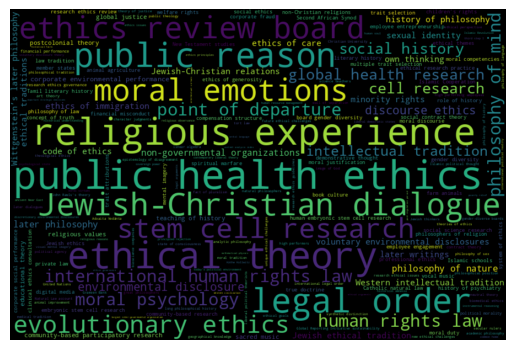

In [5]:
# take top N concepts
topn = filtered_concepts[['concept', 'frequency']][:300]

d = {x['concept'] : x['frequency'] for x in topn.to_dict(orient="records")}

wordcloud = WordCloud(width=900, height=600).generate_from_frequencies(d)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("topics_wordcloud.png", dpi=300)

## 4. Trend analysis - 'emerging' new topics each year

In this section we will look at the concept distribution over the years. In particular, we will focus on the 'new' concepts in each year - i.e. concepts that have never appeared in previous years.

This can be easily achieved by adding a new column `first_year`, marking the earliest publication year a concept was found in.

In [5]:
# enrich initial dataframe by adding 'first_year'
concepts["first_year"] = concepts.groupby('concept')['year'].transform('min')
concepts_unique = concepts.drop_duplicates("concept")[['concept', 'frequency', 'score_avg', 'first_year']]

#@markdown ## Emerging concepts: parameters
#@markdown Start year of the publications/concepts to include
YEAR_START = 2010 #@param {type:"integer"}
#@markdown How many 'emerging' concepts to retain, for each year
CONCEPTS_PER_YEAR = 5 #@param {type:"integer"}


#
# note: we reuse the freq/score threasholds above in order to focus on concepts of interest
emerging_concepts = concepts_unique.query(f"""first_year >= {YEAR_START}""")\
                    .query(f"""frequency >= {FREQ_MIN} & frequency <= {FREQ_MAX} & score_avg >= {SCORE_MIN} """)\
                    .sort_values(["score_avg", "frequency"], ascending=False)\
                    .groupby("first_year").head(CONCEPTS_PER_YEAR)

px.treemap(emerging_concepts,
           path=['first_year', 'concept'],
           values='frequency',
           color="concept",
           color_discrete_sequence=px.colors.diverging.Spectral,
           height=600,
          )

## 5. Trend Analysis: topics growth

If we focus on concepts that appear across multiple years, it is pretty interesting to examine their growth / decrease by comparing their frequency (or score) across those years.

In [6]:
#
# create dataframe with statistics for all years
#

concepts_by_year = concepts.copy()
concepts_by_year['frequency_year'] = concepts_by_year.groupby(['year', 'concept'])['concept'].transform('count')
concepts_by_year['score_avg_year'] = concepts_by_year.groupby(['year', 'concept'])['score'].transform('mean').round(5)

concepts_by_year = concepts_by_year.drop_duplicates(subset=['concept', 'year'])\
                    [['concept', 'frequency', 'score_avg', 'year', 'frequency_year', 'score_avg_year']]


#
# pick 3 frequent concepts programmatically
#

temp = concepts_unique.query(f"""frequency >= 10 & frequency <= 100 & score_avg >= 0.4 """)\
                    .sort_values(["frequency", "score_avg", ], ascending=False)
FOCUS = temp['concept'].to_list()[:3]


#
# plot their frequency over the years
#

data = concepts_by_year[concepts_by_year['concept'].isin(FOCUS)].sort_values("year")

px.line(data,
        x="year",
        y="frequency_year",
        color="concept",
       )


## 6. Trend analysis: growth distribution based on selected years

We can generalised the method above so to look at the topics that grew the most, within any two chosen years.

In [7]:
YEAR_START = 2014 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2019 #@param {type: "slider", min: 1950, max: 2020}


#
# from two years, find all common concepts, calculate growth for all of them
#

first_year = concepts_by_year.query(f"year == {YEAR_START}")
second_year = concepts_by_year.query(f"year == {YEAR_END}")
two_years = pd.concat([first_year, second_year])
common_concepts = two_years[two_years.duplicated('concept')].reset_index()[['concept', 'frequency', 'score_avg']]

def calculate_difference(concept, column="frequency_year"):
    """Compare a numeric col value across two years
    eg `calculate_difference("mind", "frequency_year")`
    """
    concept = concept.replace("'", "\\'")
    return second_year.query(f"concept == '{concept}'")[column].values[0] - first_year.query(f"concept == '{concept}'")[column].values[0]

common_concepts['freq_growth'] = common_concepts.apply(lambda x: calculate_difference(x['concept'], "frequency_year"), axis=1)
common_concepts['score_growth'] = common_concepts.apply(lambda x: calculate_difference(x['concept'], "score_avg_year"), axis=1)

common_concepts.sort_values("freq_growth", ascending=False).head()


,concept,frequency,score_avg,freq_growth,score_growth
64,properties,111,0.12084,18,-0.14609
284,order,209,0.21746,16,-0.04792
33,role,304,0.25963,16,0.05842
20,community,194,0.36021,15,-0.16620
6,system,205,0.19762,14,-0.01079


We can build a simple scatter plot using the `freq_growth` and `score_growth` values just calculated.

* by using the `MIN_SCORE` parameter we can filter out concepts with an overall `score_avg` which is too low (note: this value is the average from all years, see section 1 above)
* by mapping `score_avg` to the dots color, we can quickly visually identify concepts with a high score in the graph

In [8]:
MIN_SCORE = 0.2

px.scatter(common_concepts.query(f"score_avg >= {MIN_SCORE}"),
           x="freq_growth", y="score_growth",
            color="score_avg",
           hover_name="concept", hover_data=['concept', 'frequency', 'score_avg'],
            height=600, title=f"Concepts growth from {YEAR_START} to {YEAR_END}"
          )

## 7. Conclusion

In this tutorial we have demonstrated how to process publication *concepts* - normalised keywords found in documents- obtained using the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/).

By playing with parameters like *frequency* and *average score*, it is possible to highlight interesting concepts programmatically and use them to carry out semantic analyses of the documents dataset they derive from.

For more information on this topic, see also the [official documentation on concepts](https://docs.dimensions.ai/dsl/language.html#searching-using-concepts) and the [Working with concepts in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/7-Working-with-concepts.html) tutorial.